# Choosing an adaptive binning on-the-fly for a lightcurve


This notebook proposes a way to choose the most convenient stacking of datasets for lightcurve construction according to a user-defined condition.

This is useful if you want to display a lightcurve in a way that highlight certain aspects (e.g. variability), without knowing the properties beforehand.

The construction proceeds in a very similar way when compared to the usual short-observation lightcurve construction in Gammapy.

In [194]:
import logging
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

log = logging.getLogger(__name__)

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import LightCurveEstimator, FluxPointsEstimator
from gammapy.estimators.utils import get_rebinned_axis
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.modeling import Fit


We select the data from a datastore (in this case we will use the HESS dlr data release on PKS2155)

In [195]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
target_position = SkyCoord(329.71693826 * u.deg, -30.2255890 * u.deg, frame="icrs")
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_position.ra,
    lat=target_position.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 21


We define the geometry for the estimator

In [196]:
# Target definition
energy_axis = MapAxis.from_energy_bounds("0.4 TeV", "20 TeV", nbin=10)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.1 TeV", "40 TeV", nbin=20, name="energy_true"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

In [197]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [198]:
spectral_model = PowerLawSpectralModel(
    index=3.4, amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)
spectral_model.parameters["index"].frozen = False
spectral_model.parameters["amplitude"].frozen = False


sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="pks2155")

We split the observation as finely as possible: here we use 2 minutes observations.

In [277]:
t0 = Time("2006-07-29T20:30")
duration = 120 * u.s
n_time_bins = 175
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]
short_observations = observations.select_time(time_intervals)

We define a threshold condition for our stacking: as a first proposal, we can use a threshold value on the TS

In [278]:
def check_condition_ts(datasets):
    stat = datasets.stat_sum()
    with datasets.parameters.restore_status():
        datasets.parameters["amplitude"].value = 1e-150
        ts = datasets.stat_sum() - stat
    return np.sqrt(ts)>=40.

In [ ]:
We then loop over the observations and compute the condition for a temporary cache of datasets. When the condition is met, we stack the 

In [279]:
datasets_temp = Datasets()
optimal_datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for i, obs in enumerate(short_observations):
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets_temp.append(dataset_on_off)
    datasets_temp.models = sky_model
    fit_result = Fit().run(datasets_temp)
    fit_results_temp.append(fit_result)
    condition = check_condition_ts(datasets_temp)
    if condition or obs==short_observations[-1]:
        stacked = datasets_temp.stack_reduce()
        optimal_datasets.append(stacked)
        datasets_temp = Datasets()


In [280]:
optimal_datasets.models = sky_model

In [281]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.1, 50] * u.TeV,
    source="pks2155",
    selection_optional="all",
)
lc_maker_1d.norm.scan_max = 10

In [282]:
lc_1d = lc_maker_1d.run(optimal_datasets)

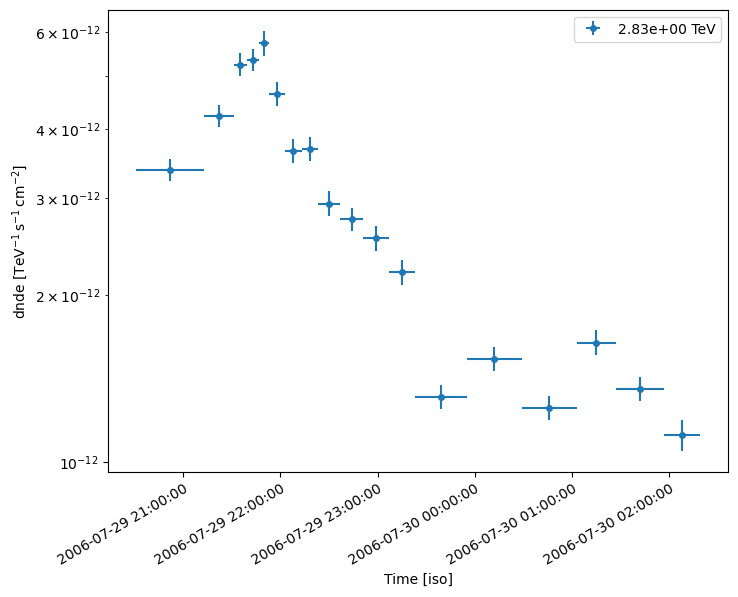

In [283]:
plt.figure(figsize=(8, 6))
lc_1d.plot(marker="o")
plt.show()